![](/images/blog/compartments.png)

Long-range chromatin contact patterns reveal that chromatin is partitioned into distinct "[compartments](https://pubmed.ncbi.nlm.nih.gov/19815776/)" - contiguous stretches of chromatin on the order of megabases in size whose epigenetic modifications and associated protein factors cause them to be positioned close to similarly-modified compartments in three-dimensional space within the nucleus. In this post, we will take a look at one line of approaches for computationally identifying compartments in Hi-C datasets - one that uses the _trans_ contact profile for each locus in the genome as a feature vector.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gilgi/gilgi.github.com/blob/src/posts/compartments.ipynb)

<!-- TEASER_END -->

We will install some non-standard packages: `hic-straw` to enable us to get contact matrices from .hic files and `lib5c` to plot contact heatmaps with extra information aligned to the axes.

In [0]:
!pip -q install hic-straw lib5c

     |████████████████████████████████| 16.2MB 284kB/s 
     |████████████████████████████████| 1.2MB 38.3MB/s 


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import coo_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from straw import straw
from lib5c.plotters.extendable.extendable_heatmap import ExtendableHeatmap

First, we will load a balanced trans contact matrix for the interaction between chr1 and chr2 in GM12878 cells from the Rao et al. 2014 dataset at 1 Mb resolution (just to keep this example notebook fast). `hic-straw` allows us to query a remote .hic file from S3 without downloading the whole thing to the local disk, which is quite convenient. We will immediately send the data we get from `hic-straw` into a standard scipy sparse matrix.

In [0]:
hic_file = 'https://hicfiles.s3.amazonaws.com/hiseq/gm12878/in-situ/combined.hic'
res = 1000000
row, col, data = map(np.array, straw('KR', hic_file, '1', '2', 'BP', res))
row = row // res
col = col // res
matrix = coo_matrix((data, (row, col))).toarray()

HiC version:  7


We will transpose the matrix so that the rows represent bins on chr2 - in this notebook we will be focusing on assigning bins on chr2 to different clusters that represent compartments.

In [0]:
matrix = matrix.T

There are a few outlier rows we identified that formed single-bin outlier clusters in the clustering steps below - we will set these outlier rows to all zeros for now. If there are a lot of zero rows in the matrix, it's possible that they may form their own cluster - a more robust approach would be to drop the zero and outlier rows to ensure they don't influence the clustering.

In [0]:
matrix[[89, 90, 91, 92], :] = 0

We can visualize the contact heatmap to see the classic "plaid" long range interaction pattern characteristic of compartments.

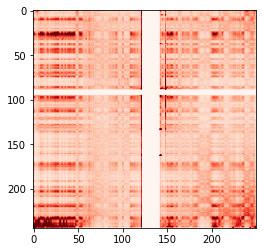

In [0]:
plt.imshow(matrix, cmap='Reds', vmin=0, vmax=1000)

We can z-score the matrix and perform PCA on the z-scores, keeping only the first principle component. The projection onto the first principle component (which gets stored in `loadings`) can be used as a continuous "compartment score".

In [0]:
scaler = StandardScaler()
loadings = PCA(n_components=1).fit_transform(StandardScaler().fit_transform(matrix))

In [0]:
matrix.shape, loadings.shape

((244, 250), (244, 1))

We can visualize the compartment score along the y-axis of the heatmap. It correlates with the plaid pattern: one compartment has large positive compartment scores while the other has large negative compartment scores.

(244.0, 0.0)

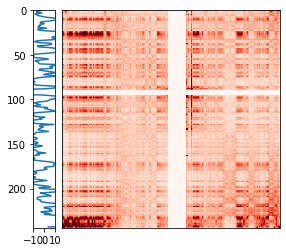

In [0]:
h = ExtendableHeatmap(
    array=matrix,
    grange_x={'chrom': 'chr1', 'start': 0, 'end': matrix.shape[1] * res},
    grange_y={'chrom': 'chr2', 'start': 0, 'end': matrix.shape[0] * res},
    colormap='Reds',
    colorscale=(0, 1000)
)
pc1_ax = h.add_ax(loc='left', name='PC1')
pc1_ax.plot(loadings[:, 0], np.arange(loadings.shape[0]))
pc1_ax.set_xlim([-10, 10])
pc1_ax.set_ylim([matrix.shape[0], 0])

We can re-do the PCA, keeping two principle components this time.

In [0]:
loadings_2 = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(matrix))

This gives us a two-dimensional embedding of each bin on chr2.

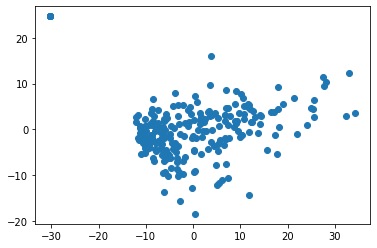

In [0]:
plt.scatter(loadings_2[:, 0], loadings_2[:, 1])

As an alternative to the continuous compartment score based on the projection onto the first principle component, we can also perform k-means clustering directly on the raw contact matrix. We can color code the points in our two-dimensional PCA plot to show that our k-means clusters represent two distinct groups of bins.

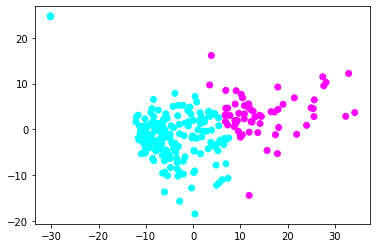

In [0]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(matrix)
plt.scatter(loadings_2[:, 0], loadings_2[:, 1], c=kmeans.labels_, cmap='cool');

Finally, we can overlay the color-coded clusters along the y-axis of the contact heatmap. Once again, we see a good correlation between the plaid pattern and the k-means clusters.

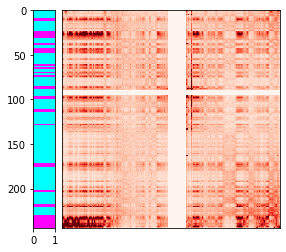

In [0]:
h = ExtendableHeatmap(
    array=matrix,
    grange_x={'chrom': 'chr1', 'start': 0, 'end': matrix.shape[1] * res},
    grange_y={'chrom': 'chr2', 'start': 0, 'end': matrix.shape[0] * res},
    colormap='Reds',
    colorscale=(0, 1000)
)
cluster_ax = h.add_ax(loc='left', name='cluster')
cluster_ax.imshow(kmeans.labels_[:, None], cmap='cool', aspect='auto',
    interpolation='none', extent=[0, 1, matrix.shape[0], 0])
cluster_ax.set_xlim([0, 1])
cluster_ax.set_ylim([matrix.shape[0], 0]);